<a href="https://colab.research.google.com/github/MhmodElgazaz/Breast-Cancer-Detection/blob/main/RSNAdatabase_VGG19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras import losses

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.utils import plot_model

import os
from IPython.display import Image
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'
!kaggle datasets download -d gauravduttakiit/mammography-breast-cancer-detection

 99% 986M/0.98G [00:13<00:00, 76.1MB/s]
100% 0.98G/0.98G [00:13<00:00, 77.9MB/s]


In [4]:
!cp mammography-breast-cancer-detection.zip /content/drive/MyDrive

In [5]:
import zipfile

# Define the path to your zip file
file_path = '/content/drive/MyDrive/mammography-breast-cancer-detection.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle/dataset')  # Replace 'destination_folder' with your desired folder

In [2]:
trainData = pd.read_csv("/content/drive/MyDrive/kaggle/dataset/train.csv")
testData = pd.read_csv("/content/drive/MyDrive/kaggle/dataset/test.csv")

In [3]:
def show_image(image):
    plt.imshow(image)
    plt.show()

In [4]:
trainData.head(5)


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [16]:
trainData


,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
87,1,10130,388811999,L,MLO,71.0,0,49,10130_L,1
88,1,10130,613462606,L,CC,71.0,0,49,10130_L,1
89,1,10130,1360338805,L,CC,71.0,0,49,10130_L,1
90,1,10130,1672636630,L,MLO,71.0,0,49,10130_L,1
190,1,10226,461614796,L,MLO,71.0,0,49,10226_L,1
...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,49,9973_R,0
54702,1,9989,63473691,L,MLO,60.0,0,216,9989_L,0
54703,1,9989,1078943060,L,CC,60.0,0,216,9989_L,0
54704,1,9989,398038886,R,MLO,60.0,0,216,9989_R,0


In [12]:
import pandas as pd
# Assuming your DataFrame is named 'df' and the column is named 'cancer'
value_to_delete = 0
num_rows_to_delete = 2000
# Filter rows with the specified value in the 'cancer' column
rows_to_delete = trainData[trainData['cancer'] == value_to_delete].head(num_rows_to_delete)
# Drop the selected rows from the DataFrame
trainData = trainData.drop(rows_to_delete.index)
# Now, 'df' contains the DataFrame with 20,000 rows where the value in the 'cancer' column is 0 deleted


In [13]:
trainData['cancer'].value_counts()

0    3548
1    1158
Name: cancer, dtype: int64

In [14]:
lb = LabelEncoder()
#trainData['cancer'] = lb.fit_transform(trainData['cancer'])
encoded_labels  = to_categorical(trainData['cancer'])

In [17]:
encoded_labels[4705]
# encoded_labels[0]

array([1., 0.], dtype=float32)

In [ ]:
# def read_images_labels(num_images=20000):
#     # define the every images filepaths into a list
#     images = []
#     labels = []

#     for idx, row in tqdm(trainData.iterrows(), total=len(trainData)):
#         if idx >= num_images:
#             break  # exit the loop if the desired number of images is reached

#         image_address = "/kaggle/input/mammography-breast-cancer-detection/train/" + str(row["cancer"]) + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + ".png"
#         img = cv2.imread(image_address, 1)
#         img = cv2.resize(img, (224, 224))  # resize image

#         # Add only the original image without rotation
#         images.append(img)
#         labels.append(encoded_labels[idx])

#     return images, labels


In [ ]:
# def read_images_labels(limit=5000):
#     # define the images filepaths into a list
#     images = []
#     labels = []

#     for _, row in tqdm(trainData.iterrows(), total=len(trainData)):
#         image_address = "/kaggle/input/mammography-breast-cancer-detection/train/" + str(row["cancer"]) + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + ".png"
#         img = cv2.imread(image_address, 1)
#         img = cv2.resize(img, (224, 224))  # resize image

#         # Check the label and add to the corresponding category
#         label = row['cancer']
#         if label == 0 and len(labels) < limit:
#             images.append(img)
#             labels.append(encoded_labels[0])
#         elif label == 1:
#             images.append(img)
#             labels.append(encoded_labels[87])

#     return images, np.array(labels)


In [ ]:
# def read_images_labels():
#     # define the every images filepaths into a list
#     images = []
#     labels = []

#     for _, row in tqdm(trainData.iterrows(), total=len(trainData)):

#         image_address = "/kaggle/input/mammography-breast-cancer-detection/train/" + str(row["cancer"]) + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + ".png"
#         img = cv2.imread(image_address, 1)
#         img = cv2.resize(img, (224, 224))  # resize image

#         # Add only the original image without rotation
#         images.append(img)
#         labels.append(row['cancer'])

#     return images, labels


In [18]:
def read_images_labels():
    # define the images filepaths into a list
    images = []
    labels = []

    for _, row in tqdm(trainData.iterrows(), total=len(trainData)):
        image_address = "/content/drive/MyDrive/kaggle/dataset/train/" + str(row["cancer"]) + "/" + str(row["patient_id"]) + "_" + str(row["image_id"]) + ".png"
        img = cv2.imread(image_address, 1)
        img = cv2.resize(img, (224, 224))  # resize image

        # Check the label and add to the corresponding category
        label = row['cancer']
        if label == 0:
            images.append(img)
            labels.append(encoded_labels[4705])
        elif label == 1:
            images.append(img)
            labels.append(encoded_labels[0])

    return images, np.array(labels)


In [19]:
X, Y = read_images_labels()

100%|██████████| 4706/4706 [00:31<00:00, 148.75it/s]


In [20]:
X = np.asarray(X)
X.shape

(4706, 224, 224, 3)

In [25]:
Y = np.array(Y)
Y.shape
Y[0]

array([0., 1.], dtype=float32)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=2021,shuffle=True)

In [27]:
y_test[1]

array([1., 0.], dtype=float32)

In [37]:
base_model = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_12 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_12 (Ba  (None, 25088)             100352    
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 1024)              25691136  
                                                                 
 batch_normalization_13 (Ba  (None, 1024)              4096      
 tchNormalization)                                    

In [ ]:
from tensorflow.keras.utils import model_to_dot
from IPython.display import Image

plot_model(model, to_file='model_architecture.png' ,show_shapes=True, show_layer_names=True)
Image(filename='model_architecture.png')

In [132]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
es = EarlyStopping(monitor='val_loss', mode='min', patience=6,restore_best_weights=True, verbose=1)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.15,shuffle=True, epochs=40, batch_size=64,callbacks=[es])

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

# Define a simple learning rate schedule function
def lr_schedule(epoch):
    initial_learning_rate = 0.05
    decay_factor = 0.9
    decay_steps = 1  # Adjust this based on your preference

    return initial_learning_rate * decay_factor**(epoch // decay_steps)

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping callback
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Compile the model with the optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with learning rate scheduling and early stopping
history = model.fit(x_train, y_train, validation_split=0.15, shuffle=True,
                    epochs=40, batch_size=256, callbacks=[es, lr_scheduler])


Epoch 1/40
27/27 [==============================] - 75s 2s/step - loss: 0.9872 - accuracy: 0.6965 - val_loss: 13.5818 - val_accuracy: 0.7367 - lr: 0.0100
Epoch 2/40
27/27 [==============================] - 22s 819ms/step - loss: 0.5377 - accuracy: 0.7529 - val_loss: 2.8133 - val_accuracy: 0.7367 - lr: 0.0090
Epoch 3/40
27/27 [==============================] - 24s 906ms/step - loss: 0.4573 - accuracy: 0.7853 - val_loss: 1.2970 - val_accuracy: 0.7300 - lr: 0.0081
Epoch 4/40
27/27 [==============================] - 22s 819ms/step - loss: 0.3298 - accuracy: 0.8609 - val_loss: 1.3378 - val_accuracy: 0.7100 - lr: 0.0073
Epoch 5/40
27/27 [==============================] - 22s 826ms/step - loss: 0.1759 - accuracy: 0.9335 - val_loss: 1.4010 - val_accuracy: 0.6733 - lr: 0.0066
Epoch 6/40
27/27 [==============================] - 22s 832ms/step - loss: 0.1016 - accuracy: 0.9632 - val_loss: 1.5453 - val_accuracy: 0.6917 - lr: 0.0059
Epoch 7/40
27/27 [==============================] - 25s 924ms/step

In [39]:
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

23/23 [==============================] - 3s 136ms/step - loss: 1.4394 - accuracy: 0.7436
Test_loss_value = 1.439377784729004
test_accuracy = 0.743626058101654


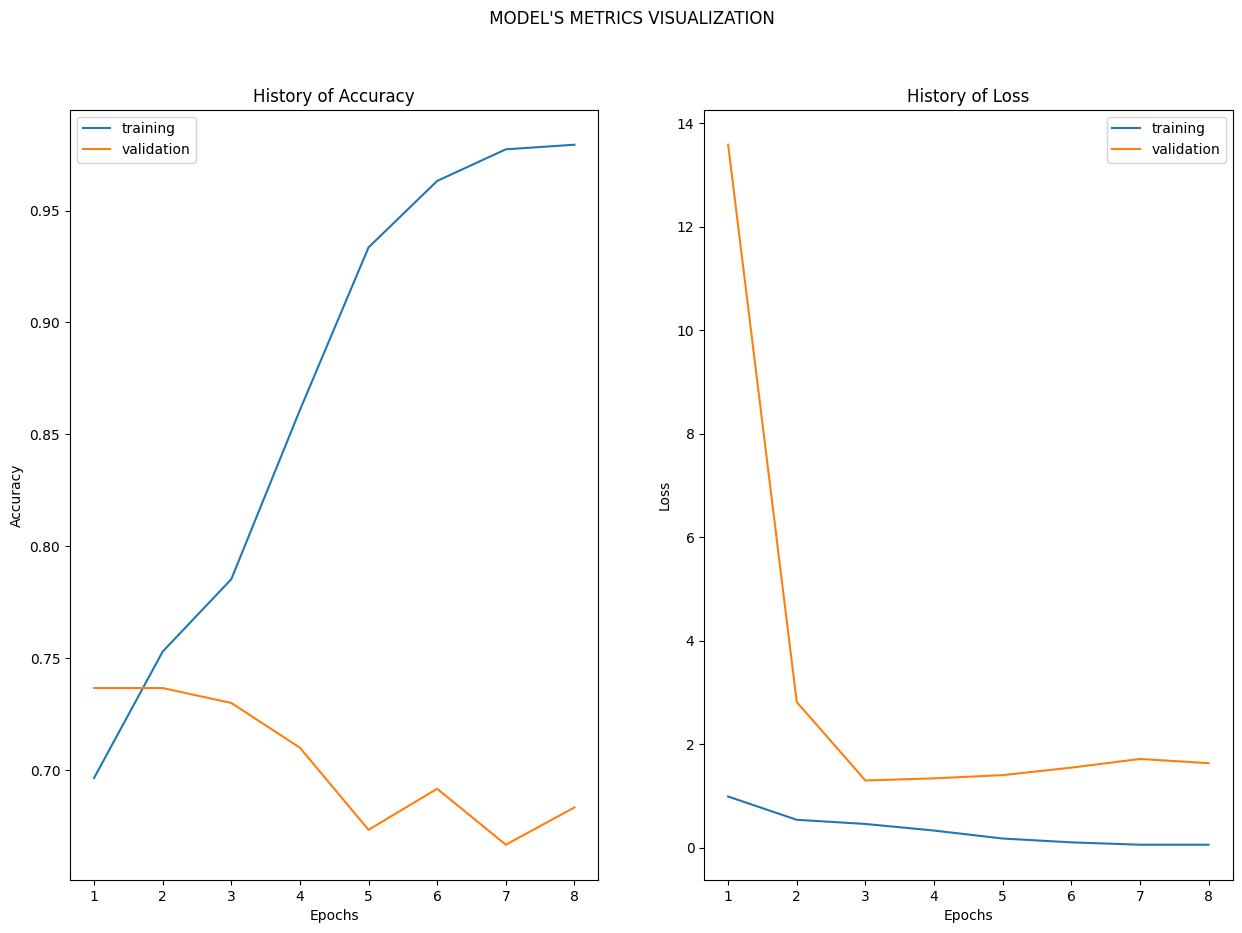

In [40]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [124]:
predictions = model.predict(x_test)
y_pred = [np.argmax(w) for w in predictions]

32/32 [==============================] - 5s 146ms/step


In [125]:
y_test = [np.argmax(w) for w in y_test]

<Axes: title={'center': 'the confusion matrix of the model in the train'}>

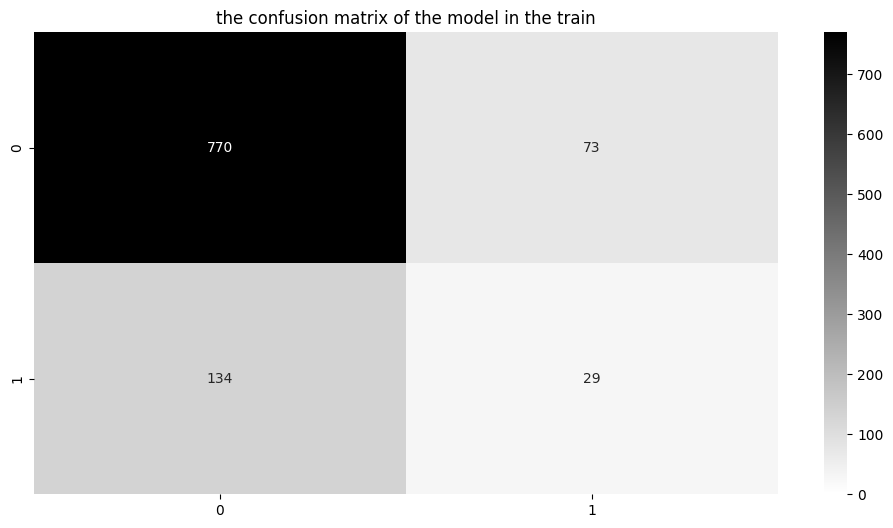

In [126]:
cm1 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 6))
plt.title('the confusion matrix of the model in the train')
sns.heatmap(cm1, annot = True, fmt = 'g' ,vmin = 0, cmap = 'binary')

In [127]:
label_mapping = {
    1: 'M',
    0: 'B'
}

classification_report_model = classification_report(y_test, y_pred, target_names=label_mapping.values())
print(classification_report_model)

              precision    recall  f1-score   support

           M       0.85      0.91      0.88       843
           B       0.28      0.18      0.22       163

    accuracy                           0.79      1006
   macro avg       0.57      0.55      0.55      1006
weighted avg       0.76      0.79      0.77      1006



In [81]:
tf.saved_model.save(model,'model')
model.save('Final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
trained_model = tf.keras.models.load_model('Final_model.h5')

from PIL import Image, ImageOps
import numpy as np

def preprocess_image(image_input):
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = Image.open(image_input).convert('RGB')
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.LANCZOS)
    image_array = np.asarray(image)
    data[0] = image_array
    return data

def make_prediction(model, image_data):
    prediction = model.predict(image_data)
    class1 = prediction[0, 0]
    class2 = prediction[0, 1]
    return class1, class2

def show_image_from_path(image_path):
    # Read the image using cv2.imread
    img = cv2.imread(image_path, 1)
    img = cv2.resize(img, (224,224))
    # Display the image using plt.imshow
    plt.imshow(img)
    plt.show()




In [ ]:
import os

# Assuming you have a folder containing multiple images for prediction
folder_path = '/kaggle/input/mammography-breast-cancer-detection/test/'
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png')]

for image_path in image_paths:
    # Preprocess the image
    preprocessed_data = preprocess_image(image_path)

    # Make prediction
    class1_prob, class2_prob = make_prediction(trained_model, preprocessed_data)

    # Display the prediction result
    print(f"Prediction for {image_path}:")
    print(f"Benign Tumor Probability: {class1_prob:.4f}")
    print(f"Malignant Tumor Probability: {class2_prob:.4f}")

    if class1_prob > class2_prob:
        print("Predicted Class: Non-cancerous")
    elif class2_prob > class1_prob:
        print("Predicted Class: Cancer")
    else:
        print("We encountered an ERROR. This should be temporary. Please try again with a better quality image. Cheers!")

    show_image_from_path(image_path)


In [ ]:
import os

# Assuming you have a folder containing multiple images for prediction
folder_path = '/kaggle/input/mammography-breast-cancer-detection/train/1/'
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png')]

for image_path in image_paths:
    # Preprocess the image
    preprocessed_data = preprocess_image(image_path)

    # Make prediction
    class1_prob, class2_prob = make_prediction(trained_model, preprocessed_data)

    # Display the prediction result
    print(f"Prediction for {image_path}:")
    print(f"Benign Tumor Probability: {class1_prob:.4f}")
    print(f"Malignant Tumor Probability: {class2_prob:.4f}")

    if class1_prob > class2_prob:
        print("Predicted Class: Benign Tumor")
    elif class2_prob > class1_prob:
        print("Predicted Class: Malignant Tumor")
    else:
        print("We encountered an ERROR. This should be temporary. Please try again with a better quality image. Cheers!")

    show_image_from_path(image_path)


In [ ]:
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Assuming you have a folder containing multiple images for prediction
folder_path = '/content/drive/MyDrive/Test/1/'
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith('.png')]
results_table = []
# Set the number of columns for image display
num_columns = 3
# Calculate the number of rows required
num_images = len(image_paths)
num_rows = -(-num_images // num_columns)  # Ceiling division to ensure all images are displayed
# Set the size of the displayed images
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 5))
for i, image_path in enumerate(image_paths):
    # Preprocess the image
    preprocessed_data = preprocess_image(image_path)
    # Make prediction
    class1_prob, class2_prob = make_prediction(trained_model, preprocessed_data)
    # Determine the predicted class
    if class1_prob > class2_prob:
        predicted_class = "Non_cancerous Tumor"
    elif class2_prob > class1_prob:
        predicted_class = "Cancerous Tumor"
    else:
        predicted_class = "ERROR"
    # Append results to the table
    results_table.append([image_path, predicted_class])
    # Plot the image with the result
    row_index = i // num_columns
    col_index = i % num_columns
    img = mpimg.imread(image_path)
    axes[row_index, col_index].imshow(img, cmap='gray')  # Specify colormap as 'gray'
    axes[row_index, col_index].set_title(f"Prediction: {predicted_class}")
    axes[row_index, col_index].axis('off')  # Turn off axis for cleaner display
# Adjust layout for better spacing
plt.tight_layout()
# Display the results table
headers = ["Image Path", "Prediction"]
print(tabulate(results_table, headers, tablefmt="grid"))
# Show the plots
plt.show()

1/1 [==============================] - 0s 48ms/step
+----------+-----------------+-------------------+
| Image    | True Label      | Predicted Label   |
+==========+=================+===================+
| Image 37 | Non_cancerous   | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 38 | Non_cancerous   | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 39 | cancerous Tumor | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 40 | Non_cancerous   | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 41 | Non_cancerous   | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 42 | Non_cancerous   | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 43 | Non_cancerous   | Non_cancerous     |
+----------+-----------------+-------------------+
| Image 44 | Non_cancerous   | cancerous Tumor   |
+----------+-----------------+

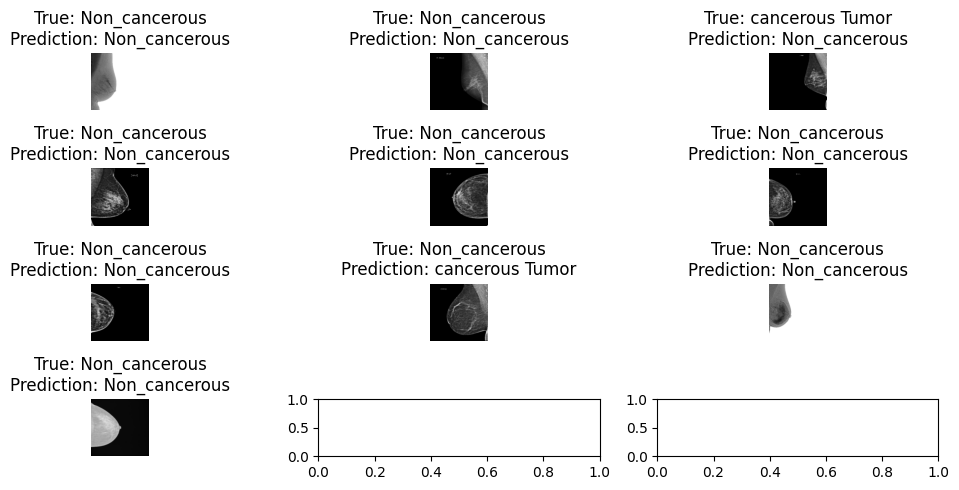

In [110]:
import os
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np

results_table = []

# Set the number of columns for image display
num_columns = 3

# Specify the range of indices you want to display (from 16 to 30)
start_index = 36
end_index = 45
indices_to_display = range(start_index, min(end_index + 1, len(x_test)))

# Calculate the number of rows required
num_images = len(indices_to_display)
num_rows = -(-num_images // num_columns)  # Ceiling division to ensure all images are displayed

# Set the size of the displayed images
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 5))

for i, index in enumerate(indices_to_display):
    # If Z[index] is a NumPy array representing the preprocessed image
    img = x_test[index]

    # Ensure the batch dimension is added correctly
    img_batch = np.expand_dims(img, axis=0)

    # Make prediction (replace this with your actual prediction function)
    class_probabilities = trained_model.predict(img_batch)

    # Determine the predicted class
    predicted_class = np.argmax(class_probabilities)
    true_class = np.argmax(y_test[index])

    class_labels = ["Non_cancerous", "cancerous Tumor"]

    # Append results to the table
    results_table.append([f"Image {index + 1}", class_labels[true_class], class_labels[predicted_class]])

    # Plot the image with the result
    row_index = i // num_columns
    col_index = i % num_columns
    axes[row_index, col_index].imshow(x_test[index], cmap='gray')  # Use the original image without reshaping
    axes[row_index, col_index].set_title(f"True: {class_labels[true_class]}\nPrediction: {class_labels[predicted_class]}")
    axes[row_index, col_index].axis('off')  # Turn off axis for cleaner display

# Adjust layout for better spacing
plt.tight_layout()

# Display the results table
headers = ["Image", "True Label", "Predicted Label"]
print(tabulate(results_table, headers, tablefmt="grid"))

# Show the plots
plt.show()
